library(tidyverse)
library(gridExtra)
library(lmtest)
library(estimatr)

In [2]:
data_preprocessed = read.csv("data_preprocessed.csv", header = T)
data = data_preprocessed
head(data)

MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,log_price,Age,HasBasement,HasGarage,HasFireplace
60,RL,65,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,2,2008,WD,Normal,12.24770,5,Yes,Yes,No
20,RL,80,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,5,2007,WD,Normal,12.10902,31,Yes,Yes,Yes
60,RL,68,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,9,2008,WD,Normal,12.31717,7,Yes,Yes,Yes
70,RL,60,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,2,2006,WD,Abnorml,11.84940,91,Yes,Yes,Yes
60,RL,84,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,12,2008,WD,Normal,12.42922,8,Yes,Yes,Yes
50,RL,85,9.555064,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,700,10,2009,WD,Normal,11.87061,16,Yes,Yes,No


In [3]:
table<-function(x,...){
    x%>%
    group_by(...)%>%
    summarise(mean_price = round(mean(exp(log_price)), 0),
              ci_price = paste0("\u00B1 ", round(1.96*(sd(exp(log_price)) / sqrt(nrow(data))), 0)),
              mean_sq = round(mean(exp(LotArea)), 0),
              ci_sq = paste0("\u00B1 ", round(1.96*(sd(exp(LotArea)) / sqrt(nrow(data))), 0)),
              Count = n(),
              "Average Sale Price" = paste0(mean_price, " (", ci_price, ")"),
              "Average Lot Area" = paste0(mean_sq, " (", ci_sq, ")"),
              "Median Age" = round(median(Age),0))%>%
    select(-c(mean_sq, ci_sq, mean_price, ci_price))
}

In [4]:
table(data,HouseStyle)%>%
    rename("House Style" = "HouseStyle")

House Style,Count,Average Sale Price,Average Lot Area,Median Age
1.5Fin,154,143118 (± 2784),11450 (± 916),70
1.5Unf,14,110151 (± 976),7120 (± 94),78
1Story,726,175986 (± 3953),10645 (± 525),36
2.5Fin,8,220001 (± 6064),12469 (± 315),94
2.5Unf,11,157356 (± 3280),9154 (± 116),93
2Story,445,210053 (± 4480),10326 (± 330),13
SFoyer,37,135075 (± 1564),7674 (± 182),32
SLvl,65,166704 (± 1965),10539 (± 176),37


In [5]:
table(data,OverallQual)%>%
    rename("Overall Quality" = "OverallQual")

Overall Quality,Count,Average Sale Price,Average Lot Area,Median Age
1,2,50151 (± 787),7511 (± 182),74
2,3,51771 (± 731),7841 (± 78),73
3,20,87475 (± 1266),8360 (± 169),73
4,116,108422 (± 1489),8919 (± 304),54
5,397,133524 (± 1390),10154 (± 472),49
6,374,161604 (± 1851),10028 (± 474),37
7,319,207717 (± 2281),11077 (± 722),8
8,168,274737 (± 3278),11105 (± 282),5
9,43,367514 (± 4169),13425 (± 333),2
10,18,438589 (± 8196),19871 (± 703),1


**Let "below average" denote houses with overall quality less than or equal to $4$; "average", $5$ and $6$; and "above average" to be $7$ and above:**

In [6]:
data[,"OverallQual"]<-factor(data[,"OverallQual"], 
                             levels = c(1:10), 
                             labels = c(rep("Below Average", 4),
                                        rep("Average", 2),
                                        rep("Above Average", 4)))

In [7]:
table(data,OverallQual)%>%
    rename("Overall Quality" = "OverallQual")

Overall Quality,Count,Average Sale Price,Average Lot Area,Median Age
Below Average,141,103419 (± 1568),8797 (± 284),59
Average,771,147145 (± 1781),10093 (± 473),45
Above Average,548,248386 (± 4347),11559 (± 599),6


***BedroomAbvGr* is the number of bedrooms above ground. The six properties (see table below) with no bedrooms probably only have bedrooms in the basement instead. Clearly, most properties have between $2$ and $4$ bedrooms:**

In [8]:
table(data,BedroomAbvGr)

BedroomAbvGr,Count,Average Sale Price,Average Lot Area,Median Age
0,6,221494 (± 5472),18153 (± 874),30
1,50,173163 (± 5282),7869 (± 287),16
2,358,158199 (± 4011),8484 (± 407),44
3,804,181058 (± 3272),10856 (± 529),32
4,213,220422 (± 5617),12923 (± 605),38
5,21,180820 (± 3512),12363 (± 425),88
6,7,143780 (± 1357),9311 (± 135),43
8,1,200001 (± NA),10897 (± NA),93


**As such, it seems more appropriate to treat the number of bedrooms as a categorical variable with four levels:**
- Two bedrooms or less
- Three bedrooms
- Four bedrooms or more

In [9]:
data[,"Bedrooms"]<-NA
for(i in 1:nrow(data)){
    if(data[i,"BedroomAbvGr"] <= 2){
        data[i,"Bedrooms"]<-"2 or less"
    }else if(data[i,"BedroomAbvGr"] == 3){
        data[i,"Bedrooms"]<-"3"
    }else{
        data[i,"Bedrooms"]<-"4"
    }
}
data[,"Bedrooms"]<-as.factor(data[,"Bedrooms"])

In [10]:
table(data,Bedrooms)

Bedrooms,Count,Average Sale Price,Average Lot Area,Median Age
2 or less,414,160923 (± 4217),8550 (± 407),38
3,804,181058 (± 3272),10856 (± 529),32
4,242,214684 (± 5436),12762 (± 582),40


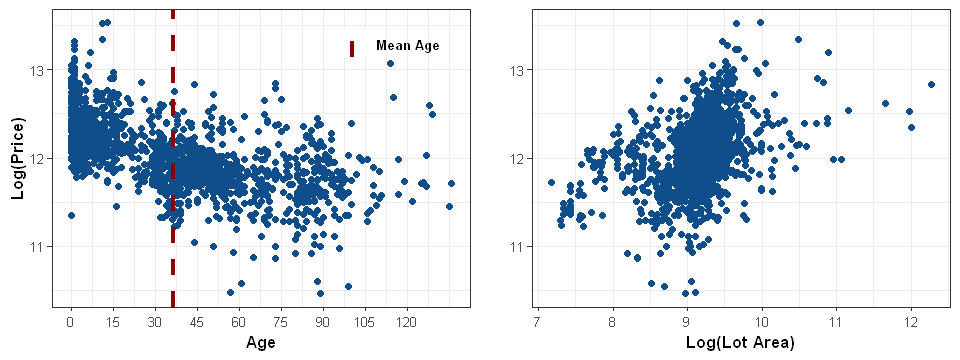

In [11]:
options(repr.plot.width = 8, repr.plot.height = 3)

age_price_plot<-data%>%
    ggplot()+
    geom_point(aes(Age, log_price), color = "dodgerblue4")+
    labs(x = "Age", y = "Log(Price)")+
    scale_x_continuous(breaks = seq(0, 120, 15))+
    geom_vline(data = data,aes(xintercept = mean(data[,"Age"]), linetype = "Mean Age"),
                               size = 1.3, color = "darkred")+
    scale_linetype_manual(values = c("Mean Age" = "dashed"))+
    theme_bw()+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 8),
          legend.title = element_blank(),
          legend.background = element_blank(),
          legend.text = element_text(size = 8, face = "bold"),legend.position = c(0.80,0.90))

sqf_price_plot<-data%>%
    ggplot()+
    geom_point(aes(LotArea, log_price), color = "dodgerblue4")+
    labs(x = "Log(Lot Area)", y = "")+
    theme_bw()+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 8))

grid.arrange(age_price_plot, sqf_price_plot, ncol = 2, nrow = 1)

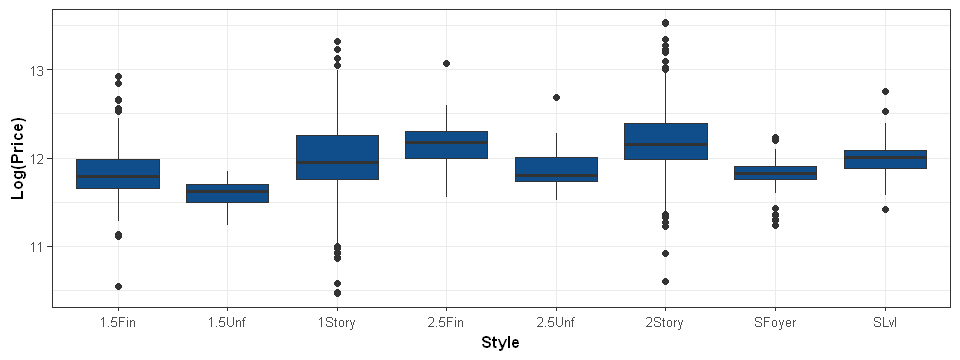

In [12]:
data%>%
    ggplot()+
    geom_boxplot(aes(HouseStyle, log_price), fill = "dodgerblue4")+
    theme_bw()+
    labs(x = "Style", y = "Log(Price)")+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 8))

In [15]:
eq<-"log_price ~ LotArea + Age + I(Age**2) + Bedrooms"
model<-lm(eq, data)
summary(model)


Call:
lm(formula = eq, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.24436 -0.14374 -0.00186  0.14564  0.98179 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.888e+00  1.227e-01  80.573  < 2e-16 ***
LotArea      2.714e-01  1.371e-02  19.792  < 2e-16 ***
Age         -1.694e-02  6.560e-04 -25.816  < 2e-16 ***
I(Age^2)     9.940e-05  6.765e-06  14.692  < 2e-16 ***
Bedrooms3    4.542e-02  1.615e-02   2.812  0.00499 ** 
Bedrooms4    2.052e-01  2.179e-02   9.420  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.257 on 1454 degrees of freedom
Multiple R-squared:  0.5875,	Adjusted R-squared:  0.586 
F-statistic: 414.1 on 5 and 1454 DF,  p-value: < 2.2e-16


$$\hat{log(price)} = 9.89 + 0.27log(Lot Area) - 0.017Age + 0.00099Age^2 + 0.045Three\text{ } Bedrooms + 0.21Four \text{ } Bedrooms $$

- Every 10% increase in the lot size increases a residential property's sale price by $3\%$.
- Older houses tend to be slightly less expensive. Nonetheless, the age of a house is shown to have decreasing marginal effects on price.
- Compared to a house with two bedrooms, a house with an additional bedroom is $4.5\%$ more expensive on average. Holding everything else constant, a four bedroom house is $21\%$ more expensive than one with only two or less bedrooms. 

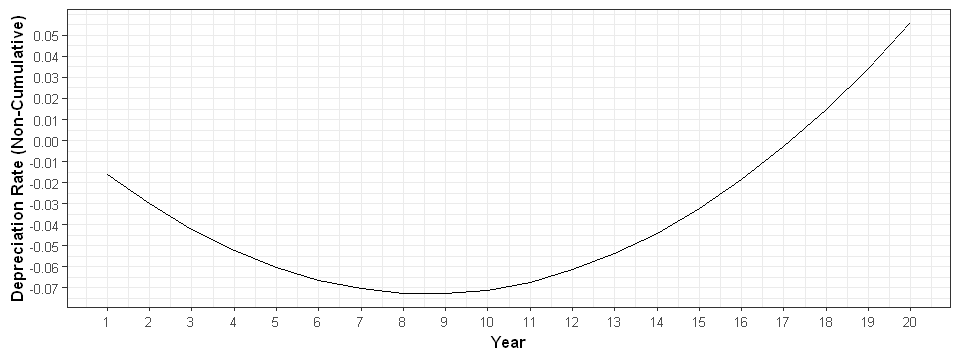

In [40]:
x<-c(1:20)
depreciation_rate<-function(x){
    -0.017*x + 0.00099*(x**2)
}
rates<-vector()
for(i in 1:length(x)){
    rates[i]<-depreciation_rate(x[i])
}
data.frame(x, rates)%>%
    ggplot()+
    geom_line(aes(x, rates))+
    labs(x = "Year", y = "Depreciation Rate (Non-Cumulative)")+
    scale_x_continuous(breaks = seq(1, 20, 1))+
    scale_y_continuous(breaks = seq(-0.10, 0.05,0.01))+
    theme_bw()+
    theme(axis.title = element_text(size = 10, face = "bold"),
          axis.text = element_text(size = 8))